In [1]:
import os
import time
import mxnet as mx
import numpy as np

from mxnet import gluon, image, init, nd
from mxnet import autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.data.vision import ImageFolderDataset
from gluoncv.utils import makedirs
from gluoncv.model_zoo import get_model
from matplotlib import pyplot as plt 

In [2]:
#Data Description
#Train Data: 100 images
#Val Data: 50 images
#Classes: Bengal and Siamese cat
# + Munchkin

In [2]:
#Hypterparameters
classes = 3
epochs = 3
lr = 0.001
momentum = 0.9
wd = 0.0001
ctx = [mx.cpu()]
batch_size = 8

In [3]:
#Data Augmentation
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=jitter_param, contrast=jitter_param, saturation=jitter_param),
    transforms.RandomLighting(lighting_param),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, .0225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, .0225])
])

In [4]:
path = './data/images'
train_path = os.path.join(path, 'cat_train')
val_path = os.path.join(path, 'cat_val')
test_path = os.path.join(path, 'cat_test')

train_data = gluon.data.DataLoader(
    ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True
)

val_data = gluon.data.DataLoader(
    ImageFolderDataset(val_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False
)

test_data = gluon.data.DataLoader(
    ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size
)

/Users/tomriddle/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Ignoring ./data/images/cat_train/.DS_Store, which is not a directory.
  import sys
/Users/tomriddle/miniconda3/lib/python3.7/site-packages/mxnet/gluon/data/vision/datasets.py:312: UserWarning: Ignoring ./data/images/cat_train/bengal_cat/.DS_Store of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))
/Users/tomriddle/miniconda3/lib/python3.7/site-packages/mxnet/gluon/data/vision/datasets.py:312: UserWarning: Ignoring ./data/images/cat_train/bengal_cat/.ipynb_checkpoints of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))
/Users/tomriddle/miniconda3/lib/python3.7/site-packages/mxnet/gluon/data/vision/datasets.py:312: UserWarning: Ignoring ./data/images/cat_train/munchkin_cat/.DS_Store of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))
/Users/tomriddle/miniconda3/lib/python3.7/site-packages/mxnet/gluon/data/visio

In [5]:
#Load Resnet
model_name = 'ResNet50_v2'
finetune_net = get_model(model_name, pretrained = True)

#Redefine output layer
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(classes)
finetune_net.output.initialize(init.Xavier(), ctx=ctx)
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

#Since I already trained the model, I only need to load it

In [7]:
#Load trained model
SAVE_PATH ='./Params_Save'
model_path = os.path.join(SAVE_PATH, 'resnet-symbol.json')
param_path = os.path.join(SAVE_PATH, 'resnet-0009.params')
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    finetune_net = gluon.nn.SymbolBlock.imports(model_path, ['data'], param_path, ctx=ctx)


In [6]:


trainer = gluon.Trainer(finetune_net.collect_params(), 'sgd', {
    'learning_rate': lr, 'momentum': momentum, 'wd': wd
})

metric = mx.metric.Accuracy()
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [7]:
#Test
def test(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)
    return metric.get()

In [8]:
#Training loop
num_batch = len(train_data)

for epoch in range(epochs):
    tic = time.time()
    train_loss = 0
    metric.reset()
    
    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with autograd.record():
            outputs = [finetune_net(X) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(outputs, label)]
        for l in loss:
            l.backward()
        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)
        
        metric.update(label, outputs)
    
    #Finish 1 epoch
    _, train_acc = metric.get()
    train_loss /= num_batch
    
    _, val_acc = test(finetune_net, val_data, ctx)
    
    run_time = time.time() - tic
    print('[Epoch %d] Train-acc: %.3f, train-loss: %.3f | Val-acc: %.3f | time: %.3f'%
          (epoch, train_acc, train_loss, val_acc, run_time))
    

[Epoch 0] Train-acc: 0.576, train-loss: 0.889 | Val-acc: 0.442 | time: 173.446
[Epoch 1] Train-acc: 0.815, train-loss: 0.520 | Val-acc: 0.374 | time: 186.529
[Epoch 2] Train-acc: 0.818, train-loss: 0.472 | Val-acc: 0.381 | time: 163.389


In [11]:
_, test_acc = test(finetune_net, test_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Finished] Test-acc: 0.925


In [12]:
net = finetune_net

In [13]:
bengal_train = 'cat_train/bengal_cat/bengal-5.jpg'
bengal = 'cat_test/bengal_cat/Bengal-Kitten.png'
bengal_val = "cat_val/bengal_cat/image0.jpeg"
munchkin = 'cat_test/munchkin_cat/25-1.jpg'
siamese = 'cat_test/siamese_cat/Siamese.png'
siamese_val = "cat_val/siamese_cat/image11.jpeg"


test_images = [bengal_train, bengal, bengal_val, munchkin, siamese, siamese_val]
expect_result = [0, 0, 0, 1, 2, 2]
test_result = []

In [14]:
for file in test_images:
    img_path = os.path.join(path, file)
    img = mx.image.imread(img_path)   
    img_t = transform_test(img)
    img_e = img_t.expand_dims(axis=0)
    pred = net(img_e)
    idx = nd.argmax(nd.softmax(pred), axis=1)
    test_result.append(idx.asscalar().astype('int'))

In [15]:
#Test if result is correct
assert(test_result == expect_result)

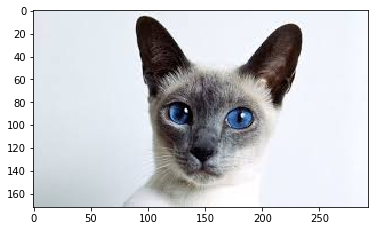

In [16]:
plt.imshow(img.asnumpy())

In [ ]:
#Save trained model
SAVE_PATH = './Params_Save'
f_name = os.path.join(SAVE_PATH, 'resnet')
finetune_net.export(f_name, epoch=9)

In [ ]:
ImageFolderDataset?

In [ ]:
dir(train_data)

In [ ]:
#Get classes
a = ImageFolderDataset(val_path)

In [ ]:
for idx, label in enumerate(a.synsets):
    print(idx, label)

In [ ]:
net.export?